# VAE Model Testing Framework

In [1]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /notebooks


# Hyperparemeters

In [2]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed':0,
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}
##### Model parameters #####
model_name = 'vae_locatello'  # Name of the model architecture file (e.g., 'vae_burgess')
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder (e.g., 'bernoulli', 'gaussian')
latent_dim = 10
use_torch_compile = True  # Use torch.compile for model compilation (requires PyTorch 2.0 or higher)

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 40

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
# Annealed VAE
loss_name = 'annealedvae'
loss_kwargs = {
    'C_init': 0.0,       # Starting capacity
    'C_fin': 25.0,       # Final capacity
    'gamma': 100.0,      # KL divergence weight
    'anneal_steps': 100000, # Steps for annealing capacity
    'rec_dist': 'gaussian', # Reconstruction distribution
    'log_kl_components': True
}


#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps=None

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
chkpt_save_master_dir=None

Using GPU


# Reproducibility

In [3]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 0, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [4]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

# Shapes3d

## Load dataset

In [5]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

if determinism_kwargs is not None:
    shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_3dshapes, 
                                                      shuffle=True, 
                                                      pin_memory=True)


print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")


Loaded 3D Shapes dataset with 480000 samples.


## Setup Model, Loss, and Optimizer

In [6]:
def setup_components(dataset, loss_kwargs):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    

    # Instantiate Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_dim=latent_dim, 
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    if loss_name == 'betatcvae':
        loss_kwargs['n_data'] = n_data
    
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## Train

In [7]:
shapes3d_loss_kwargs = loss_kwargs.copy()

In [8]:
print("\n===== Training on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)

trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                                      loss=loss_fn_3dshapes,
                                      optimizer=optimizer_3dshapes,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_log_loss=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      )

trainer_3dshapes.train(step_unit=train_step_unit, max_steps=num_train_steps, dataloader=shapes3d_dataloader)


===== Training on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: vae_locatello
Loss: annealedvae (rec_dist=gaussian), kwargs={'C_init': 0.0, 'C_fin': 25.0, 'gamma': 100.0, 'anneal_steps': 100000, 'rec_dist': 'gaussian', 'log_kl_components': True}
Optimizer: Adam
---------------------------


Training for 300000 iter, 40.00 epochs:   0%|          | 0/300000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:135: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
[2025-05-28 17:24:48,246] [0/0] torch._inductor.utils: [WARNING] not enough SMs to use max_autotune_gemm mode


{'logs': {'train_losses_log': [{'rec_loss': 1700.6540728759765,
    'kl_loss_0': 0.010341571492608637,
    'kl_loss_1': 0.006112065662164241,
    'kl_loss_2': 0.01012542207725346,
    'kl_loss_3': 0.009243727275170387,
    'kl_loss_4': 0.008307291844394058,
    'kl_loss_5': 0.009162571537308395,
    'kl_loss_6': 0.005882222908549011,
    'kl_loss_7': 0.00901917511364445,
    'kl_loss_8': 0.009015965859871357,
    'kl_loss_9': 0.009268601282965392,
    'kl_loss': 0.08647861561737955,
    'loss': 1706.9136682128906,
    'iter': 200,
    'epoch': 0.02666666666666667},
   {'rec_loss': 1530.1362731933593,
    'kl_loss_0': 0.009619018430821597,
    'kl_loss_1': 0.0050437730876728894,
    'kl_loss_2': 0.01108327393885702,
    'kl_loss_3': 0.008210463547147811,
    'kl_loss_4': 0.006059150695800781,
    'kl_loss_5': 0.007109095507767052,
    'kl_loss_6': 0.005092895771376789,
    'kl_loss_7': 0.006318527385592461,
    'kl_loss_8': 0.009533863835968078,
    'kl_loss_9': 0.007773532739374787,
  

### Visualization

In [9]:
visualizer_3dshapes = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

#### Reconstructions

Plotting random reconstructions...


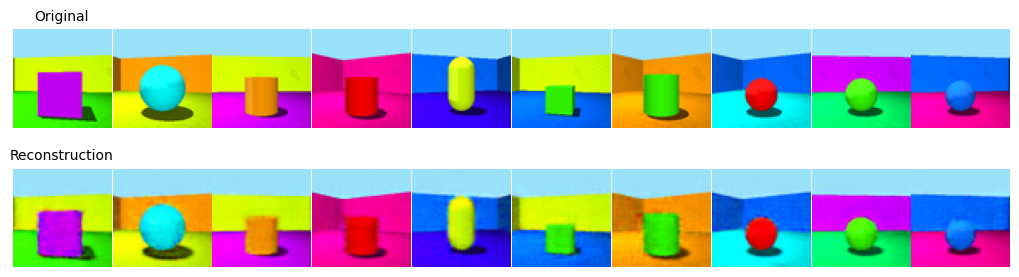

Plotting reconstructions from specific indices...


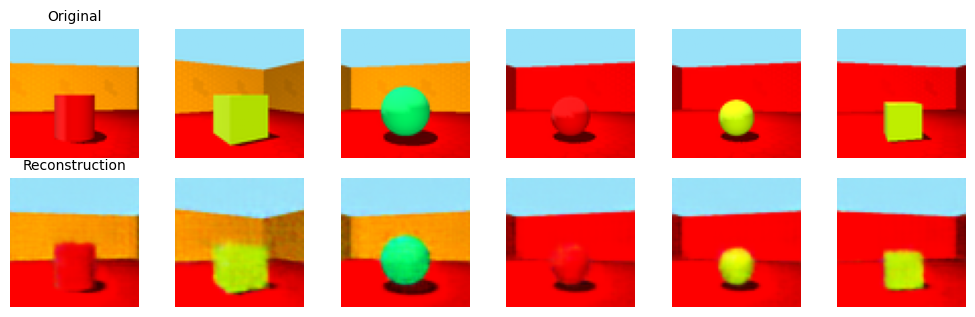

In [10]:
print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

#### Latent traversal

Plotting latent traversals...


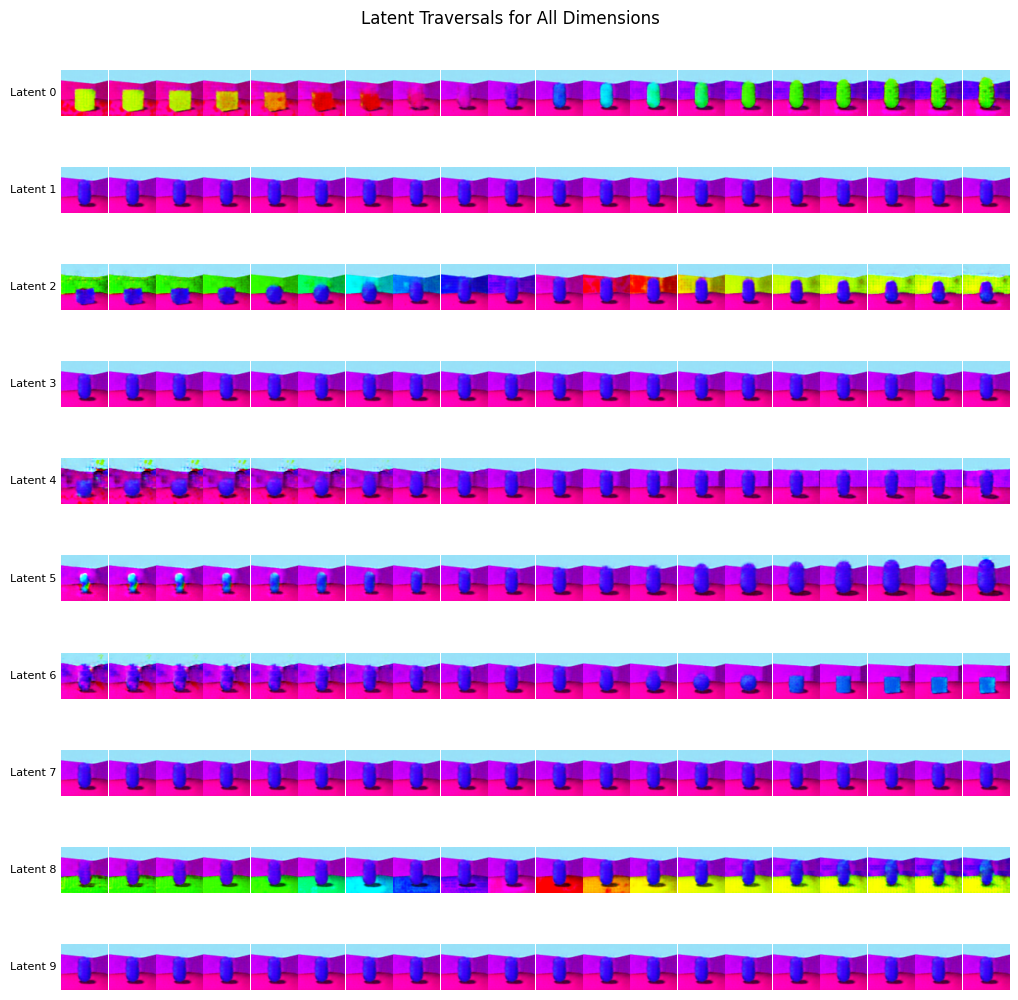

In [11]:
print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20)
plt.show()

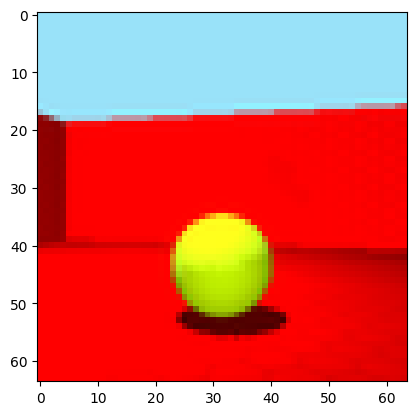

In [12]:
ref_img_idx = 1000
ref_img = shapes3d_dataset[ref_img_idx][0]
plt.imshow(ref_img.permute(1, 2, 0).cpu().numpy())

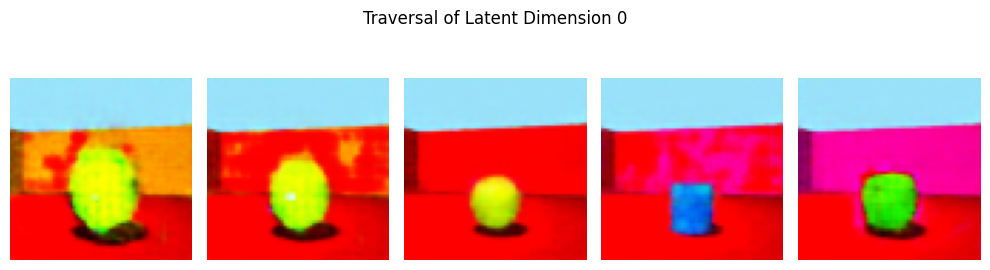

In [13]:
# single latent traversal based on the reference image
latent_idx = 0  # Index of the latent dimension to traverse
visualizer_3dshapes.plot_single_latent_traversal(latent_idx, 
                                                 ref_img=ref_img, 
                                                 num_samples=5,
                                                 max_traversal_type='absolute', 
                                                 max_traversal=2)

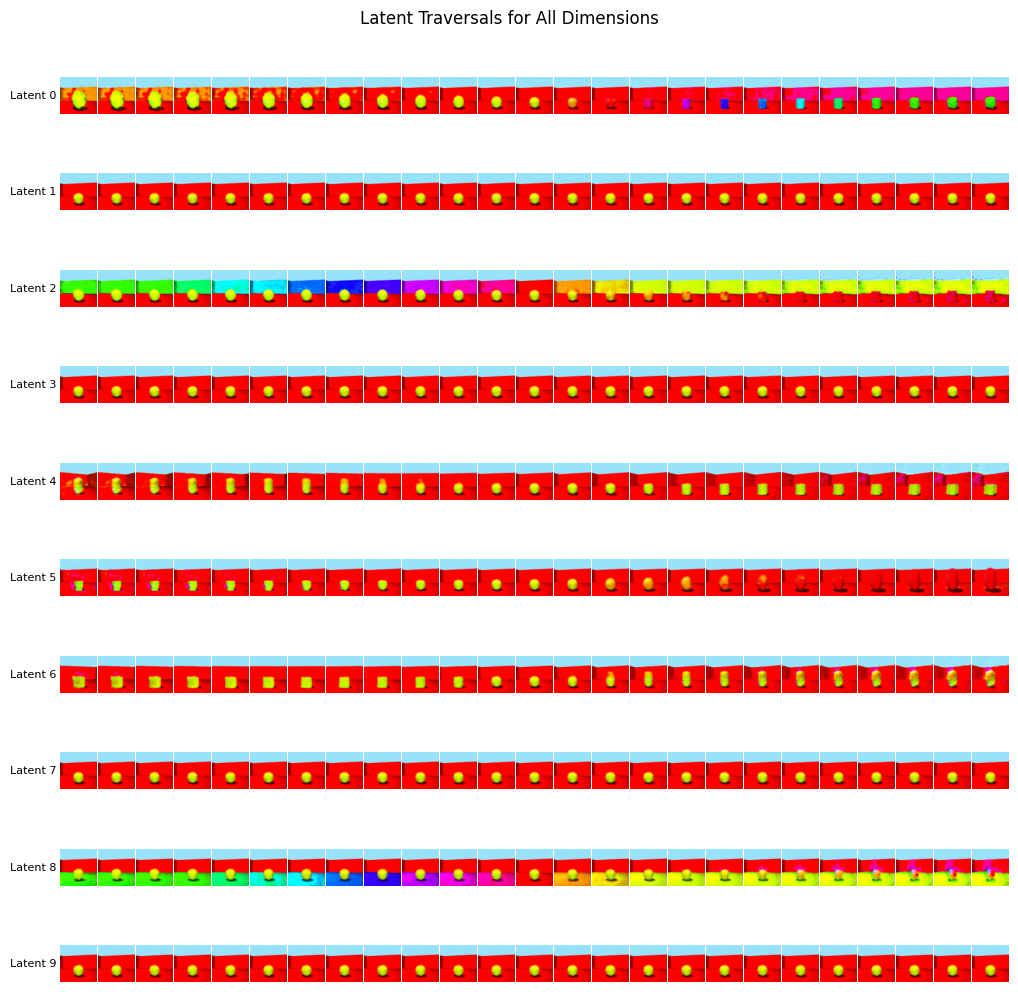

In [14]:
visualizer_3dshapes.plot_all_latent_traversals(ref_img=ref_img, 
                                               num_samples=25,  
                                               max_traversal_type='probability',
                                               max_traversal=0.95,
                                               use_ref_img_lat_std=False
                                               )

## Metric Evaluation

In [15]:
metrics_to_compute = [
    {'name': 'dci_d', 'args':{'num_train':5000, 'num_test':1000}}, # Added num_train and num_test
    {'name': 'mig', 'args':{}} # MIG uses default args (num_bins=20, num_workers=8, etc.)
]

metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

print("\n===== Computing Metrics for 3D Shapes =====")
metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes, 
                                                              data_loader=shapes3d_dataloader, 
                                                              device=device)
print("3D Shapes Metrics:", metrics_results_3dshapes)


===== Computing Metrics for 3D Shapes =====


Computing representations: 100%|██████████| 7500/7500 [00:18<00:00, 395.65it/s]


3D Shapes Metrics: {'dci_d': {'disentanglement': 0.035914181184729964, 'completeness': 0.031507120053518425, 'informativeness_train_scores': 0.6584666666666666, 'informativeness_test_scores': 0.3363333333333334, 'informativeness_train_errors': 0.3415333333333333, 'informativeness_test_errors': 0.6636666666666667}, 'mig': 0.023931348634684147}


# dSprites

In [16]:
# Load dSprites
Dsprites = get_dataset('dsprites')

dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 737280 samples.


## Train

In [17]:
# Beta VAE
loss_kwargs_beta_vae_dsprites =  {
    'beta': 16,
    'rec_dist': 'bernoulli', # Use the globally defined rec_dist
    'log_kl_components':True
               }

In [18]:
print("\n===== Training on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, loss_kwargs_beta_vae_dsprites)

trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_log_loss=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      )
trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training on dSprites =====
--- Setup for DSprites --- 
Model: vae_locatello
Loss: annealedvae (rec_dist=bernoulli), kwargs={'beta': 16, 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
---------------------------


{'logs': {'train_losses_log': [{'rec_loss': 1185.7974285888672,
    'kl_loss_0': 0.009977635499089955,
    'kl_loss_1': 0.0057896445342339575,
    'kl_loss_2': 0.00885747272055596,
    'kl_loss_3': 0.008372565626632422,
    'kl_loss_4': 0.009692944448906927,
    'kl_loss_5': 0.008225772245787084,
    'kl_loss_6': 0.0066401482000947,
    'kl_loss_7': 0.0074468007986433805,
    'kl_loss_8': 0.008564198764506727,
    'kl_loss_9': 0.007593093025498092,
    'kl_loss': 0.0811602758569643,
    'loss': 1193.9134564208985,
    'iter': 200,
    'epoch': 0.017361111111111112},
   {'rec_loss': 621.8459945678711,
    'kl_loss_0': 0.008213169788941741,
    'kl_loss_1': 0.00498572900891304,
    'kl_loss_2': 0.00705204215599224,
    'kl_loss_3': 0.00592281584860757,
    'kl_loss_4': 0.010643856129609048,
    'kl_loss_5': 0.005845462796278298,
    'kl_loss_6': 0.005677335513755679,
    'kl_loss_7': 0.00641308803576976,
    'kl_loss_8': 0.01042910329066217,
    'kl_loss_9': 0.007526681937742978,
    'kl

In [19]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.Visualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


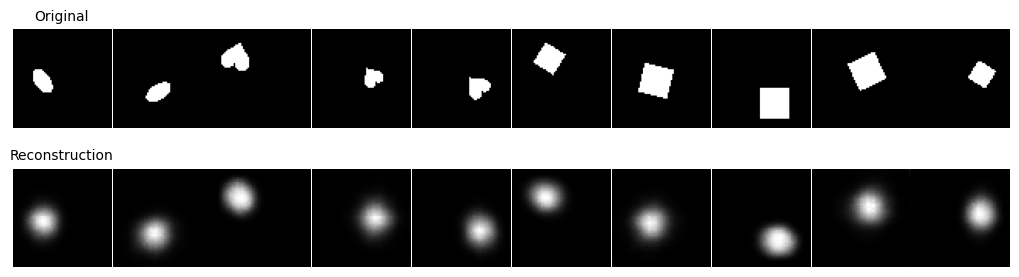

Plotting reconstructions from specific indices...


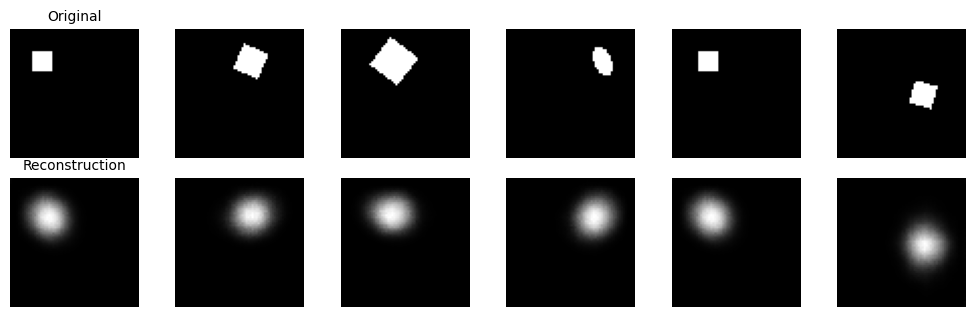

In [20]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 100000, 200000, 300000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


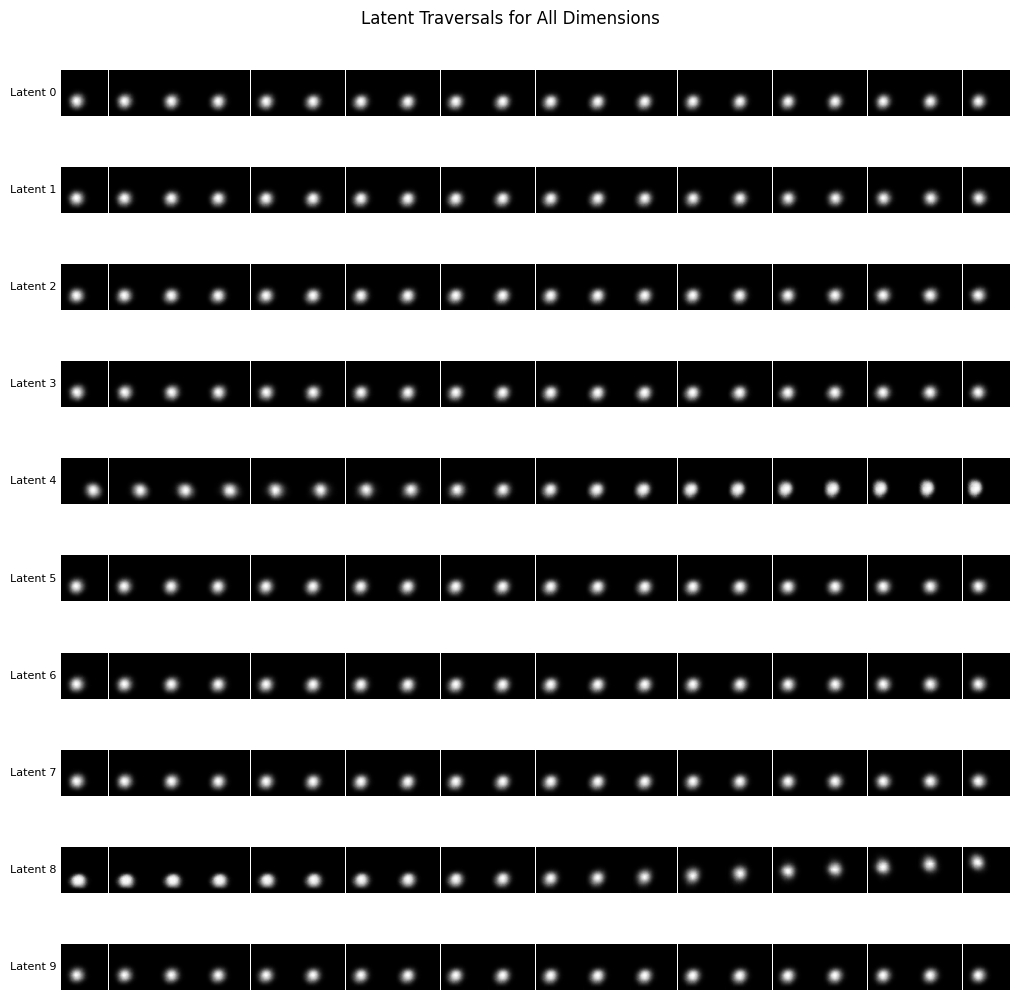

In [21]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20)
plt.show()

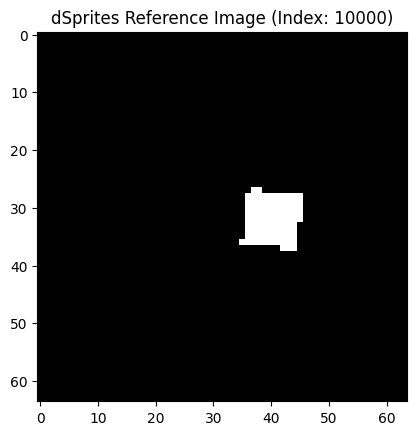

In [22]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 10000  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()


Plotting single latent traversal for dimension 0...


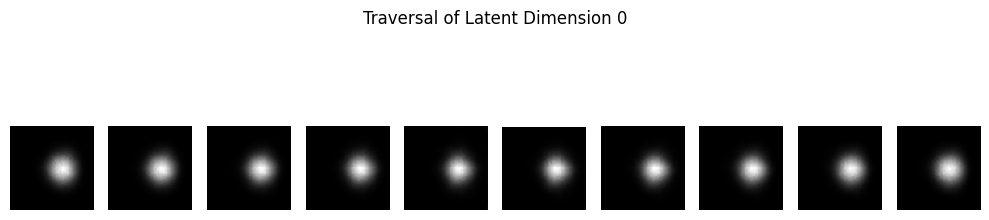

In [23]:
# Single latent traversal based on the reference image
latent_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_idx_dsprites, ref_img=ref_img_dsprites, num_samples=10)
plt.show()

Plotting all latent traversals based on reference image...


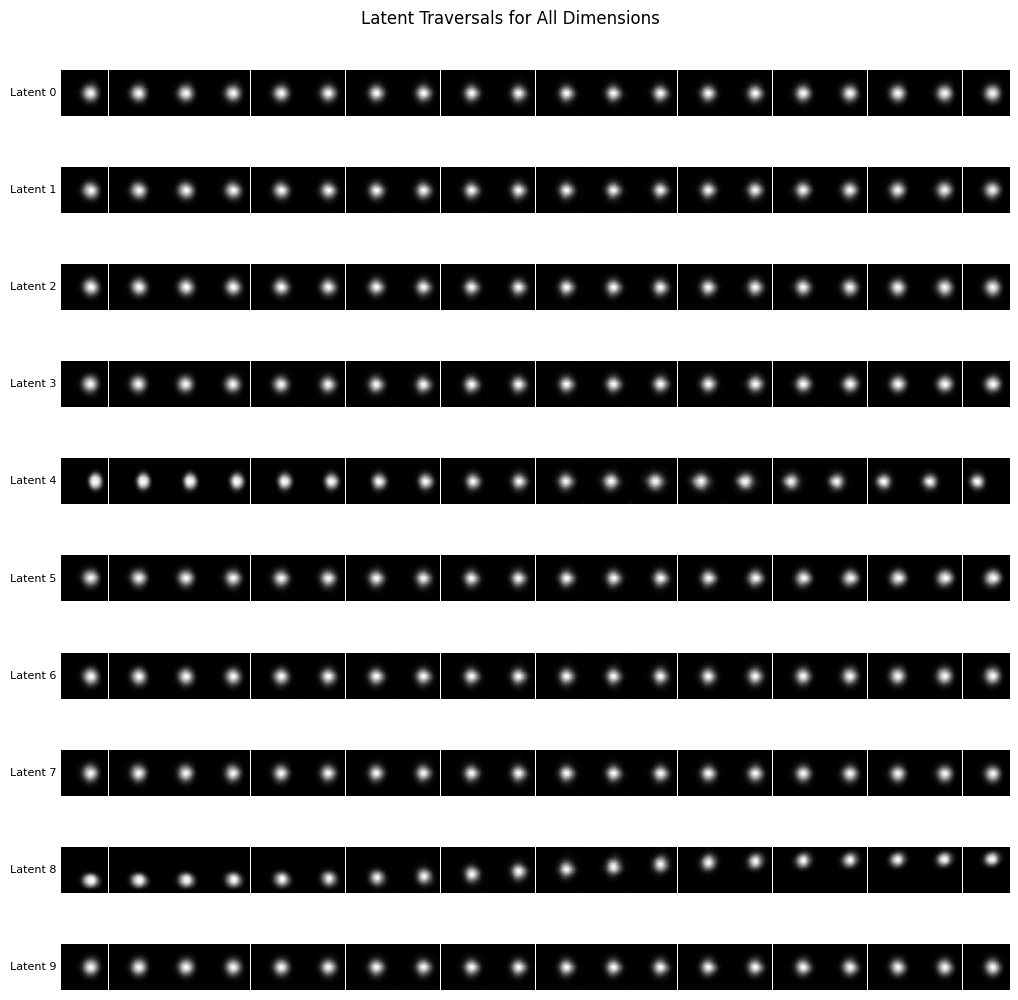

In [24]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, num_samples=20)
plt.show()

## Metric Evaluation (dSprites)

In [25]:
print("\n===== Computing Metrics for dSprites =====")
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
                                                            data_loader=dsprites_dataloader, 
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)


===== Computing Metrics for dSprites =====


Computing representations: 100%|██████████| 11520/11520 [00:20<00:00, 565.39it/s]


dSprites Metrics: {'dci_d': {'disentanglement': 0.14530226148361572, 'completeness': 0.16906112227240402, 'informativeness_train_scores': 0.79604, 'informativeness_test_scores': 0.35760000000000003, 'informativeness_train_errors': 0.20396, 'informativeness_test_errors': 0.6424}, 'mig': 0.19765953092380723}
